In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import MultivariateNormal
import pydrake
from pydrake.all import (
    MathematicalProgram,
    Solve
)
torch.set_default_dtype(torch.double)

Say we have the ability to sample points (with bias) via random sampling in an ambient space followed by projection. We'd like to do that to get lots of points in our constraint set, and then evaluate our density at those points to reconstruct the underlying distribution intersected with the constraint set.

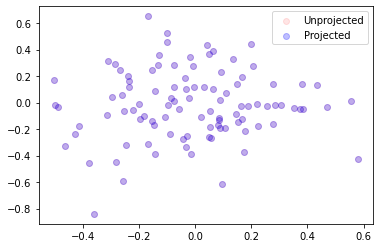

In [437]:
def do_projection(x_targ):
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(2, "x")
    prog.AddConstraint(x.T.dot(x) <= 1.)
    prog.AddCost( np.sum((x - x_targ).T.dot(x - x_targ)))
    result = Solve(prog)
    assert result.is_success()
    return result.GetSolution(x)

zs = np.random.normal(0., 0.25, (100, 2))
xs = np.stack([do_projection(z) for z in zs])
plt.scatter(zs[:, 0], zs[:, 1], color="r", alpha=0.1, label="Unprojected")
plt.scatter(xs[:, 0], xs[:, 1], color="b", alpha=0.25, label="Projected")
plt.legend()

In [438]:
true_mean = torch.tensor([0.25, -0.25])
true_var = torch.eye(2)*0.25
xs_torch = torch.tensor(xs, dtype=torch.float64)
p = MultivariateNormal(true_mean, true_var)

http://proceedings.mlr.press/v54/liu17b/liu17b.pdf

In [449]:
# Copied from https://github.com/singhalrk/stein_ksd/blob/master/kernels.py
class RBFKernel():
    def __init__(self, bw):
        self.beta = 1./bw

    def value(self, x, y):
        r = (x - y).square().sum(axis=-1)
        return torch.exp(-self.beta * r)

    def grad_x(self, x, y):
        r = (x - y).square().sum(axis=-1, keepdim=True).repeat(1, x.shape[-1])
        return - 2 * self.beta * (x - y) * torch.exp(-self.beta * r)

    def grad_y(self, x, y):
        r = (x - y).square().sum(axis=-1, keepdim=True).repeat(1, x.shape[-1])
        return 2 * self.beta * (x - y) * torch.exp(-self.beta * r)

    def grad_xy(self, x, y):
        r = (x - y).square().sum(axis=-1)
        _y = 2 * self.beta * torch.exp(-self.beta * r)
        _xy = -4 * self.beta**2 * r * torch.exp(-self.beta * r)
        return _y + _xy

In [450]:
def stein_kernel(x, y, p, kernel):
    x.requires_grad = True
    x.grad = None
    log_px = p.log_prob(x)
    log_px.backward(gradient=torch.ones_like(log_px))
    grad_log_px = x.grad
    y.requires_grad = True
    y.grad = None
    log_py = p.log_prob(y)
    log_py.backward(gradient=torch.ones_like(log_py))
    grad_log_py = y.grad
    
    x.grad = None
    y.grad = None
    kernel_val = kernel.value(x, y)
    kernel_val.backward(gradient=torch.ones_like(kernel_val))
    kernel_grad_y = y.grad
    kernel_grad_x = x.grad
    assert torch.allclose(kernel_grad_x, kernel.grad_x(x, y))
    assert torch.allclose(kernel_grad_y, kernel.grad_y(x, y))
    
    
    p1 = (grad_log_px * grad_log_py).sum(axis=-1) * kernel.value(x, y)
    p2 = (grad_log_px * kernel.grad_y(x, y)).sum(axis=-1)
    p3 = (grad_log_py * kernel.grad_x(x, y)).sum(axis=-1)
    p4 = kernel.grad_xy(x, y)
    return p1 + p2 + p3 + p4

N = len(xs_torch)
# Make two vectors of all pairs
x1 = xs_torch.unsqueeze(1).repeat(1, N, 1).reshape(N**2, 2)
x2 = xs_torch.unsqueeze(0).repeat(N, 1, 1).reshape(N**2, 2)

# Bandwidth as median of pairwise square distance
pairwise_dists = ((x1 - x2).square()).sum(axis=-1).sqrt()
median_dist = torch.median(pairwise_dists)
print("Median dist: %f" % median_dist.item())
kernel = RBFKernel(bw=median_dist)

Kp = stein_kernel(x1, x2, p, kernel).reshape(N, N)
Kp = Kp.detach().numpy()

Median dist: 0.410646


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.23155858e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

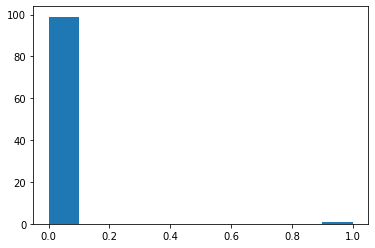

In [451]:
prog = MathematicalProgram()
w = prog.NewContinuousVariables(N, 1, "w")
prog.AddLinearConstraint(w.sum() == 1)
prog.AddBoundingBoxConstraint(np.zeros(N), np.ones(N), w)
prog.AddQuadraticCost(w.transpose().dot(Kp).dot(w)[0, 0])
result = Solve(prog)
assert result.is_success()
w = result.GetSolution(w)
plt.hist(w)
print(w)

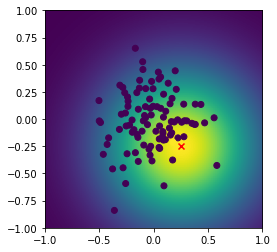

In [452]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x,y)
# evaluate kernels at grid points
xxyy = np.c_[xx.ravel(), yy.ravel()]
zz = np.exp(p.log_prob(torch.tensor(xxyy)).numpy())
# reshape and plot image
img = zz.reshape((100,100))
plt.imshow(img, extent=(-1, 1, -1, 1), origin='lower')

plt.scatter(true_mean[0], true_mean[1], c="red", marker="x")

# Show probe point weights with color mapping
plt.scatter(xs[:, 0], xs[:, 1], c=w)

In [443]:
print("Expected value of approximated dist (should be %s): %s" % (
    true_mean, (w * xs.T).sum(axis=-1)
))

Expected value of approximated dist (should be tensor([ 0.2500, -0.2500])): [ 0.14661741 -0.20284873]
